<a href="https://colab.research.google.com/github/ohtjqkd/devcourse_monthly_1/blob/main/week15_visual_recognition_2_P2P_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 과제  
 데이터셋 바꿔서 학습시켜보기

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-oal5s5ia
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-oal5s5ia
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ef3f47f8cd9367b6a86b5392edf833b7086858b1_-py3-none-any.whl size=270995 sha256=2b2cd3cb943d94f0d605944b00acb12e4b2d4bd7f4ab102640bde06d58cc5bf7
  Stored in directory: /tmp/pip-ephem-wheel-cache-sx4z1ooo/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [3]:
dataset, metadata = tfds.load('cycle_gan/monet2photo',
                              with_info=True, as_supervised=True)

train_monets, train_photos = dataset['trainA'], dataset['trainB']
test_monets, test_photos = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteT5RL9S/cycle_gan-trainA.tfrecord


  0%|          | 0/1072 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteT5RL9S/cycle_gan-trainB.tfrecord


  0%|          | 0/6287 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteT5RL9S/cycle_gan-testA.tfrecord


  0%|          | 0/121 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteT5RL9S/cycle_gan-testB.tfrecord


  0%|          | 0/751 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
def random_crop(image):
    cropped_image = tf.image.random_crop(
        image, size = [IMG_HEIGHT, IMG_WIDTH, 3]
    )
    return cropped_image

In [6]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    return image

In [7]:
def random_jitter(image):
    # resizing to 286 * 286 * 3
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # randomly cropping to 256 * 256 * 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image


In [8]:
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [9]:
def preprocess_image_test(image, label):
    image = normalize(image)
    return image


In [10]:
train_monets = train_monets.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
train_photos = train_photos.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

test_monets = test_monets.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
test_photos = test_photos.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

In [11]:
sample_monet = next(iter(train_monets))
sample_photo = next(iter(train_photos))

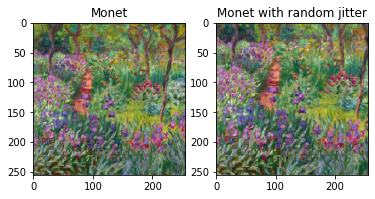

In [12]:
plt.subplot(121)
plt.title('Monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet with random jitter')
plt.imshow(random_jitter(sample_monet[0]) * 0.5 + 0.5)

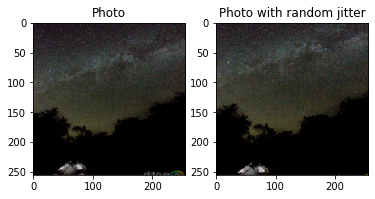

In [13]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models
  
Import the generator and the discriminator used in Pix2Pix via the installed tensorflow_examples package.  
The model architecture used in this tutorial is very similar to what we used in pix2pix. Some of the differences are:  
- Cyclegan uses instance normalization instead of batch normalization.
- The CycleGAN paper uses a modified ```ResNet``` based generator. This tutorial is using a modified ```unet``` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.
- Generator ```G``` learns to transform image ```X``` to image ```Y```. $(G:X -> Y)$
- Generator ```F``` learns to transform image ```Y``` to image ```X```. $(F:Y -> X)$
- Discriminator ```D_Y``` learns to differentiate between image ```X``` and generated image ```X```(F(Y)).
- Discriminator ```D_X``` learns to differentiate between image ```Y``` and generated image ```Y```(G(X)).



In [14]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

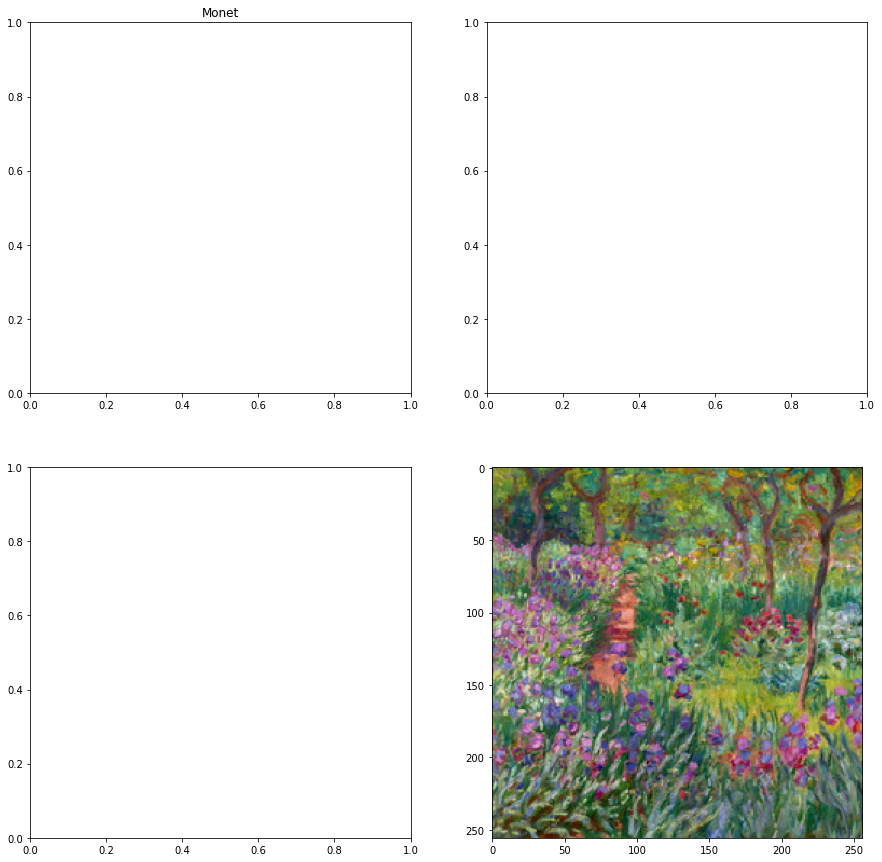

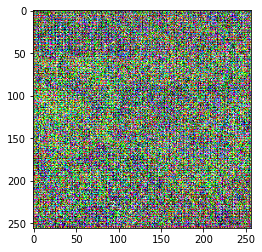

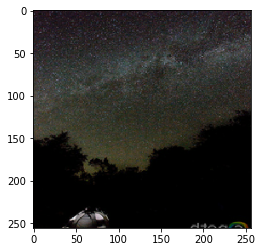

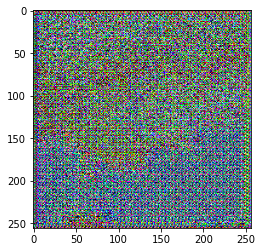

In [15]:
to_photo = generator_g(sample_monet)
to_monet = generator_f(sample_photo)
contrast = 8

imgs = [sample_monet, to_photo, sample_photo, to_monet]
title = ['Monet', 'To Photo', 'Photo', 'To monet']
fig, ax = plt.subplots(2, 2, figsize=(15,15))
for i in range(len(imgs)):
    ax[i//2][i%2].set_title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * contrast + 0.5)
    plt.show()

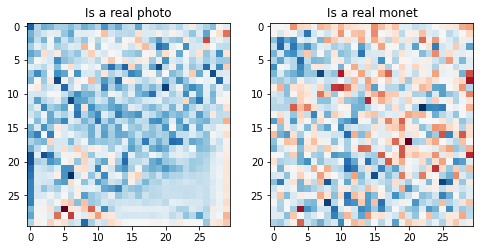

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.title('Is a real photo')
plt.imshow(discriminator_y(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real monet')
plt.imshow(discriminator_x(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [17]:
LAMBDA = 10

In [18]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [20]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [21]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [22]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image-same_image))
    return LAMBDA * 0.5 * loss

In [23]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [24]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager, latest_checkpoint)
    print('Latest checkpoint restored!!')

## Training
Note: This example model is trained for fewer epochs (40) than the paper(200) to keep training time reasonable for this tutorial.  
Predictions may be less accurate.

In [25]:
EPOCHS = 200

In [26]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize = (12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [27]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_yare used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                          generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                              discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                              discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                              generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                              generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                  discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                  discriminator_y.trainable_variables))

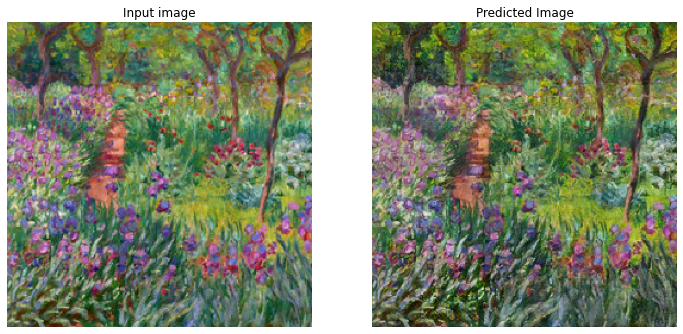

Saving checkpoint for epoch 160 at ./checkpoints/train/ckpt-35
Time taken for epoch 160 is 238.57391500473022 sec

..........................................

KeyboardInterrupt: ignored

In [29]:
with tf.device('gpu:0'):
    for epoch in range(EPOCHS):

        start = time.time()

        n = 0
        for image_x, image_y in tf.data.Dataset.zip((train_monets, train_photos)):
            train_step(image_x, image_y)
            if n % 10 == 0:
                print('.', end='')
            n += 1
        
        clear_output(wait=True)
        # Using a consistent image (sample_monet) so taht the progress of the model
        # is clearly visible
        generate_images(generator_g, sample_monet)
        if (epoch+1)%5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        
        print('Time taken for epoch {} is {} sec\n'.format(epoch+1, time.time()-start))

In [ ]:
!mv ./checkpoints/train/checkpoint ./drive/MyDrive/dev_assign/week15/

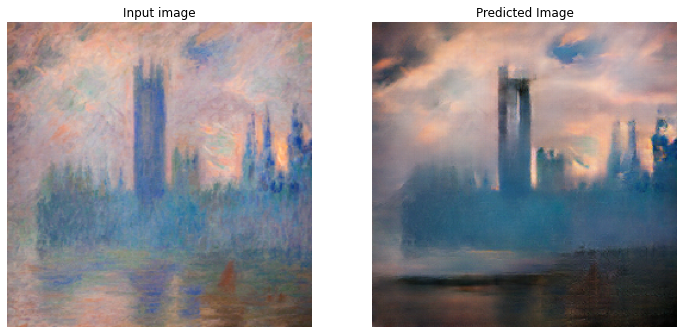

In [30]:
my_sample_monet = next(iter(train_monets))
generate_images(generator_g, my_sample_monet)

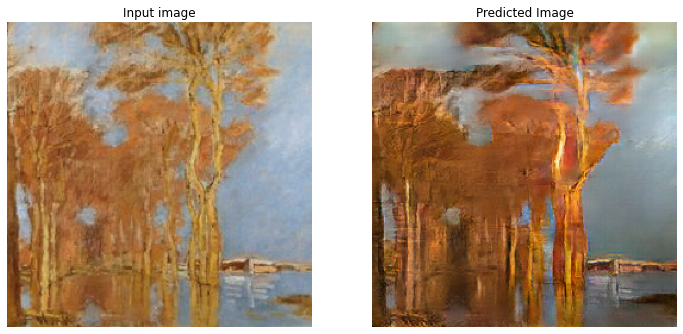

In [31]:
my1_sample_monet = next(iter(train_monets))
generate_images(generator_g, my1_sample_monet)

## 추가 이미지 결과 확인

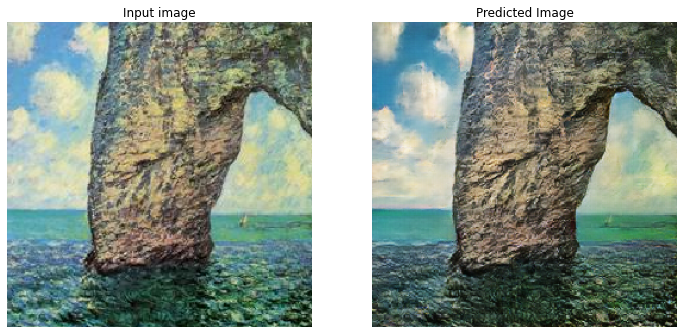

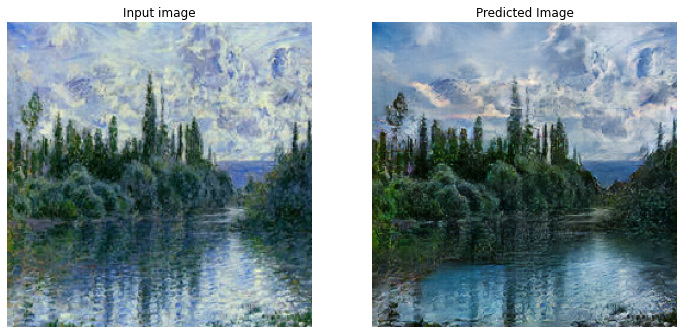

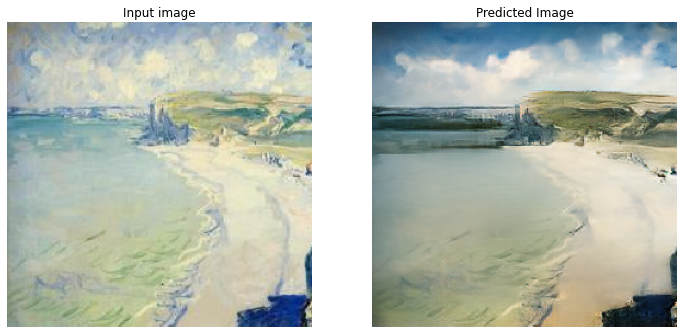

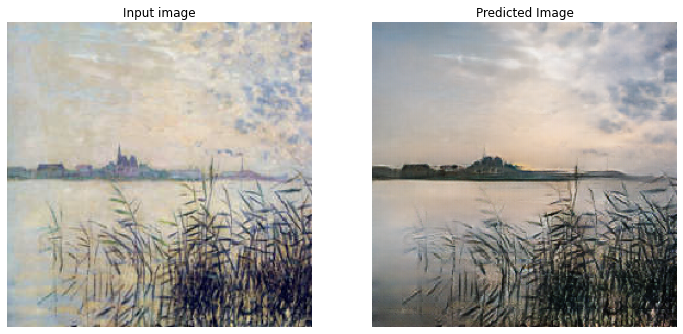

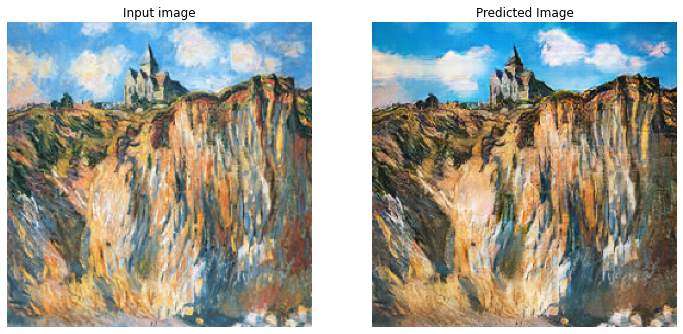

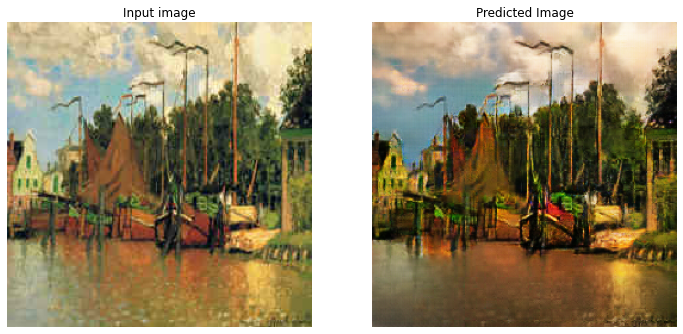

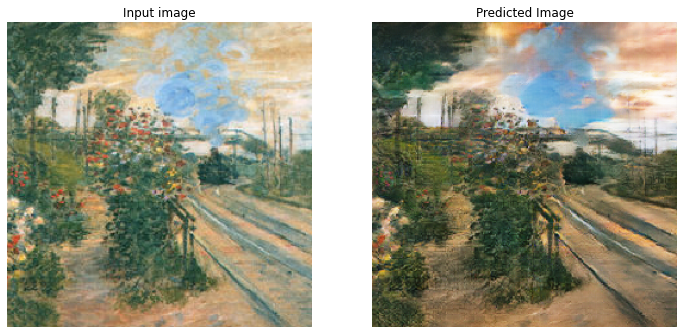

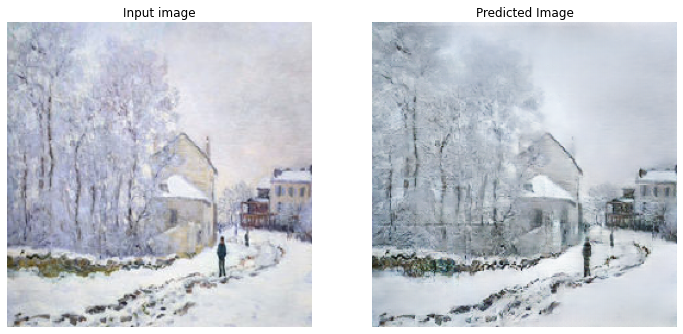

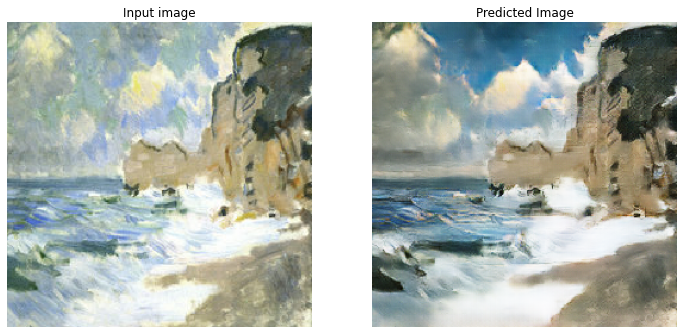

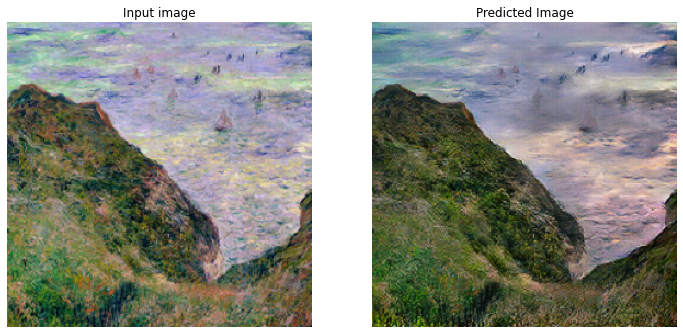

In [32]:
for i in range(10):
    generate_images(generator_g, next(iter(train_monets)))

체크 포인트 저장

In [34]:
!mv ./checkpoints/train/checkpoint ./checkpoints/train/ckpt-35* ./drive/MyDrive/dev_assign/week15/checkpoints/monet2photo/